<img src="files/night_sky_eye_small.jpg">
# Image_comparison Script

Jessica Metzger (UChicago) and Jim Annis (Fermilab) 2018


To run this notebook:
  * the geckodriver executable needs to be in the environmental variable $PATH
      **export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/
  * you'll need to run 
       ** conda activate des18a"
  * and set the python path:
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python;export PYTHONPATH;
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages;export PYTHONPATH;
       
 *(to run a notebook remotely, see 
 http://home.fnal.gov/~kadrlica/fnalstart.html
 
 ## How this should work
 
 * Given a search image:
 * Select from the 200mpc catalog the likely galaxies in the image as a list of ra,dec's
 * If in panstarrs area, run the current script for each ra, dec
     ** teach this code to know where the search image is
 * If we want to see DECam template images
 ** find the DECam images that overlap (from the diffimage pipeline or from Alex)
 *** teach the code to accept a list of template DECam images
 ** teach the code to look there for those images and deal gracefully with no matches
     *** where is there? ideally all the DECam images are on disk at Fermilab. There.


In [1]:
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time,os
import glob
import fitsio

#import ps1
import support
%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

In [2]:
# 
# given a ra,dec of a search image, 
# return the list of gals and thumbs
#
def get_list_of_gals_and_cutouts(ra,dec, path_to_cutouts="/data/des70.a/data/annis/s190510/", verbose=False) :
    file = glob.glob(path_to_cutouts + "matched*csv")
    dc_ra, dc_dec = np.genfromtxt(file[0],unpack=True,usecols=(0,1),delimiter=",", skip_header=1)
    thumb = np.genfromtxt(file[0],unpack=True,usecols=(3),delimiter=",",skip_header=1,dtype="str")
    
    distance = np.sqrt( ((ra-dc_ra)*np.cos(dc_dec*2*np.pi/360.))**2 + (dec-dc_dec)**2)
    #distance = support.gc_separation(ra, dec, dc_ra, dc_dec)
    ix = distance < 1.2
    gals_ra, gals_dec = dc_ra[ix], dc_dec[ix]
    for i in range(gals_ra.size):
        if verbose:
            print "{} {:10.5f} {:10.5f} \t {}".format(i, gals_ra[i], gals_dec[i], thumb[ix][i])
    return gals_ra, gals_dec, thumb[ix]
    
# 
# given a thumb name, return image
# return the list of gals and thumbs
#
def get_des_cutout_image(thumb_name, filter="g", path_to_cutouts="/data/des70.a/data/annis/s190510/") :
    fits = fitsio.FITS(path_to_cutouts+thumb_name+"_{}.fits".format(filter))
    img = fits[0].read()
    return img

In [136]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS

def raw_cutout(infilename, ra,dec,stampSize, verbose=True): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    
    found = False
    for ccd in range(1,63):
        if verbose: print ccd,
        header = fits.open(infilename)[ccd].header #pyfits.getheader(infilename, 0)
        #print header
        data = fits.open(infilename)[ccd].data
        try:
            ylen, xlen = data.shape[0], data.shape[1]
        except:
            if verbose: print "no data"
            continue
    
        #Find pixel at the candidate ra dec
        w = WCS(header=header) 
       
        px, py = w.all_world2pix(ra, dec, 1)
        objcoord = [px, py]
        if np.isnan(px) or np.isnan(py):
            if verbose: print "isnan"
            continue
        corners = w.calc_footprint()
        if (px < -1024 or px > 1024): continue
        if (py < -2048 or py > 2048): continue 
        print corners
        print ra,dec
        found = True
        if found: 
            print objcoord
            break
        
    if verbose: 
        if not found: 
            print "Not Found"
            return -1

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    if verbose: print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def cutout(infilename,ra,dec,stampSize): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]
   

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def find_BLISS_image(cand_ra,cand_dec,stampSize, filter):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if band != filter : continue
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if not os.path.isfile(cat_file):
            print "There is no source catalog in ", band
            exp_file = 0
            return ""
        else:
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                img = cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
                img = np.rot90(img)
                img = np.fliplr(img)
      
            return img
    
def find_search_image(image_name, cand_ra,cand_dec,stampSize, dir="/data/des51.b/data/DTS/src/20190510/"):
    exp_file = dir+image_name
    img = raw_cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
    try:
        if img == -1: return -1
    except:
        img = np.rot90(img)
        img = np.fliplr(img)
      
    return img



In [150]:
# this notation is [col_min, col_max, row_min, row_max]
# http://iraf.noao.edu/projects/ccdmosaic/imagedef/imagedef.html
def interp_header_keyword(header):
    section = header[1:-1]
    rows=section.split(",")[1]
    cols=section.split(",")[0]
    rmin= np.int(rows.split(":")[0])
    rmax= np.int(rows.split(":")[1])
    cmin= np.int(cols.split(":")[0])
    cmax= np.int(cols.split(":")[1])
    return rmin, rmax, cmin, cmax

def get_biased_data(infilename, num):
    
        data = fits.open(infilename)[num].data            
        header = fits.open(infilename)[num].header

        biassec = header["biasseca"]
        rmin, rmax, cmin, cmax = interp_header_keyword(biassec)
        bias = np.median(data[rmin:rmax, cmin:cmax])
        #print "bias a", bias
        trimsec =  header["trimseca"]
        rmin, rmax, cmin, cmax = interp_header_keyword(trimsec)
        data[rmin:rmax,cmin:cmax] = \
            data[rmin:rmax,cmin:cmax] - bias
            
        biassec = header["biassecb"]
        rmin, rmax, cmin, cmax = interp_header_keyword(biassec)
        bias = np.median(data[rmin:rmax, cmin:cmax])
        #print "bias b", bias
        trimsec =  header["trimsecb"]
        rmin, rmax, cmin, cmax = interp_header_keyword(trimsec)
        data[rmin:rmax,cmin:cmax] = \
            data[rmin:rmax,cmin:cmax] - bias
        
        
        #x="trimsec";print x,header[x]
        #x="datasec";print x,header[x]
        #x="trimseca";print x,header[x]
        #x="trimsecb";print x,header[x]
        #x="dataseca";print x,header[x]
        #x="datasecb";print x,header[x]
        #x="biasseca";print x,header[x]
        #x="biassecb";print x,header[x]
        #x="ccdseca";print x,header[x]
        #x="ccdsecb";print x,header[x]

        return data



In [221]:
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def work_image(expid, image_ra,image_dec, filter="g",
               dir="/data/des51.b/data/DTS/src/20190510/", 
               do_cutout=True, 
               do_num = -1, do_ccdnum=-1): #Stampsize is half width
    infilename = dir + "DECam_00{}.fits.fz".format(expid)
    do_bliss = True; 
    if do_cutout: do_bliss = False
    
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    
    gra,gdec,thumbs = get_list_of_gals_and_cutouts(image_ra, image_dec)
    match_cutout = 15
    go_big = 25
    #match_cutout = 15
    #if do_cutout: stampSize = match_cutout/0.27
    if do_cutout: stampSize = go_big/0.27
    if do_bliss:   stampSize = go_big/0.27

    count = 0
    for ccd in range(1,63):
        if (do_num != -1) and (do_num != ccd) : continue
        header = fits.open(infilename)[ccd].header #pyfits.getheader(infilename, 0)
        ccdnum = header["ccdnum"]
        if (do_ccdnum != -1) and (do_ccdnum != ccdnum) : continue

        print ccd,
        #print header

        have_read_data = False
        #Find pixel at the candidate ra dec
        w = WCS(header=header) 
        for i in range(0,gra.size) :
            # is the object on this ccd?
            corners = w.calc_footprint()
            ccd_ra_min = corners[:,0].min()
            ccd_ra_max = corners[:,0].max()
            ccd_dec_min = corners[:,1].min()
            ccd_dec_max = corners[:,1].max()
            #print ccd_ra_min, gra[i],ccd_ra_max
            #print ccd_dec_min, gdec[i], ccd_dec_max
            if ((gra[i] < ccd_ra_min) or (gra[i] > ccd_ra_max)) :  continue
            if ((gdec[i] < ccd_dec_min) or (gdec[i] > ccd_dec_max)) :  continue
            
            if not have_read_data:
                have_read_data = True
                fixed_data = get_biased_data(infilename, ccd)
                try:
                    ylen, xlen = fixed_data.shape[0], fixed_data.shape[1]
                except:
                    print "no data"
                    continue    
    
            px, py = w.all_world2pix(gra[i], gdec[i], 1)
            #objcoord = [px, py]
            #if np.isnan(px) or np.isnan(py):
            #    print "isnan"
            #    continue
            #if (px < 0 or px > 2048): continue
            #if (py < 0 or py > 4096): continue 

            #cutting image:
            X = int(px)  # cols before rot90 and flip
            Y = int(py)  # rows  ditto
            if ccdnum < 30 :
                Y = int(py+100)
            if ccdnum < 25 :
                X = int(px+50)
            if ccdnum > 54 :
                X = int(px+50)
                
            sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
            sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
            siz = int(np.min(np.array([sizy,sizx])))
            row_min, row_max = np.int(Y-stampSize),np.int(Y+stampSize)+1
            col_min, col_max = np.int(X-stampSize),np.int(X+stampSize)+1
            if col_min < 0: col_min = 0
            if row_min < 0: row_min = 0
            if row_max > ylen: row_max = ylen
            if col_max > ylen: col_max = xlen
            print "cutout: rows,cols {}:{}".format(row_min, row_max), 
            print " {}:{}".format(col_min,col_max+1)

      
            data = np.copy(fixed_data[row_min:row_max, col_min:col_max+1])
            data = np.rot90(data)
            data = np.fliplr(data)
            search = data


            fig,axs=plt.subplots(1,2,figsize=(15,5))
            axs=axs.ravel()
            fig.suptitle('RA = '+str(round(gra[i],6))+', DEC = '+str(round(gdec[i],6)))
    
                
            if do_cutout :
                template = get_des_cutout_image(thumbs[i], filter=filter)
                label = "DES coadd"
    
            if do_bliss:
                template = find_BLISS_image(gra[i],gdec[i],stampSize, filter)
                label = "Bliss single exposure"
            search_label="DECam_00{}.fits.fz ccd={}".format(expid,ccdnum)
                
            print "trying search + {}\n".format(label)
            try:
                axs[0].imshow(np.log10(template-np.amin(template)+1),origin='lower',cmap='gray')
                axs[0].set_title('template for gal {} {}'.format(i, label))
                axs[1].imshow(np.log10(search-np.amin(search)),origin='lower',cmap='gray')
                axs[1].set_title('search {}'.format( search_label))
                plt.show()
                count += 1
            except:
                print "exception, search image has shape",np.shape(search)
                pass
    print "\n Did {} galaxies!\n".format(count)

Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856770.fits.fz
1 2 3 cutout: rows,cols 233:419  1857:2044
Exposure available in  r
Closest object is at distance [0d00m00.5587s]
(RA,DEC)= 91.29748134836613 -35.330188235405195
Filter, mag, magerr r 16.489273 0.0016191335
Opening file: /data/des61.b/data/BLISS/502100/502134/D00502134_r_22_r1p1_immask.fits.fz
cutout: 92 509.29195142966637 2482.412024031626
trying search + Bliss single exposure



/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in log10


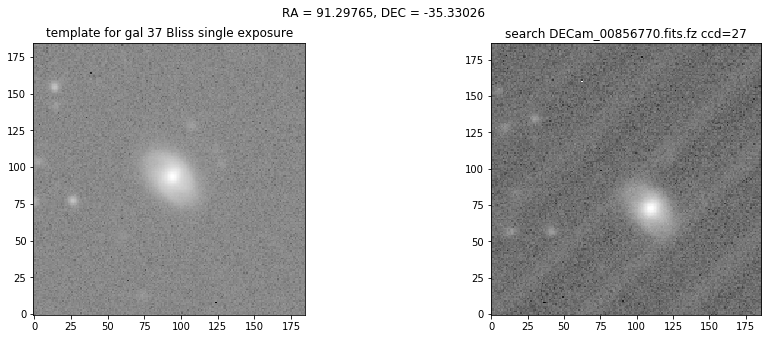

4 5 6 7 cutout: rows,cols 735:921  312:499
Exposure available in  r
Closest object is at distance [0d00m00.5815s]
(RA,DEC)= 90.77774819356098 -35.044738464120144
Filter, mag, magerr r 15.859274 0.0015166497
Opening file: /data/des61.b/data/BLISS/597600/597684/D00597684_r_16_r1p1_immask.fits.fz
cutout: 92 1614.6910192213882 3951.8865557878116
trying search + Bliss single exposure



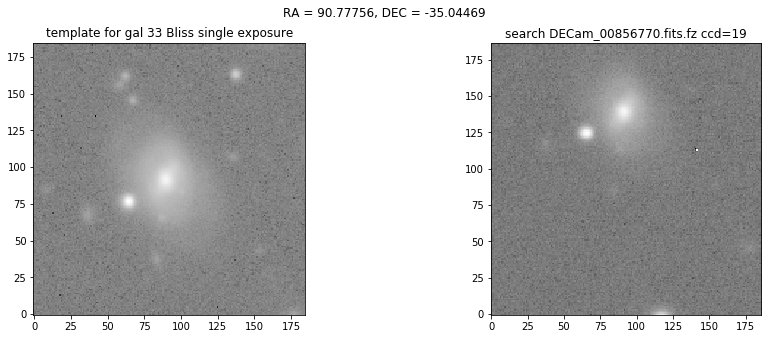

8 cutout: rows,cols 2661:2847  0:174
Exposure available in  r
Closest object is at distance [0d00m00.0183s]
(RA,DEC)= 91.32772379456124 -35.025249829220655
Filter, mag, magerr r 16.380934 0.00184403
Opening file: /data/des61.b/data/BLISS/597600/597684/D00597684_r_18_r1p1_immask.fits.fz
cutout: 92 1384.815651173315 1620.2883679923443
trying search + Bliss single exposure



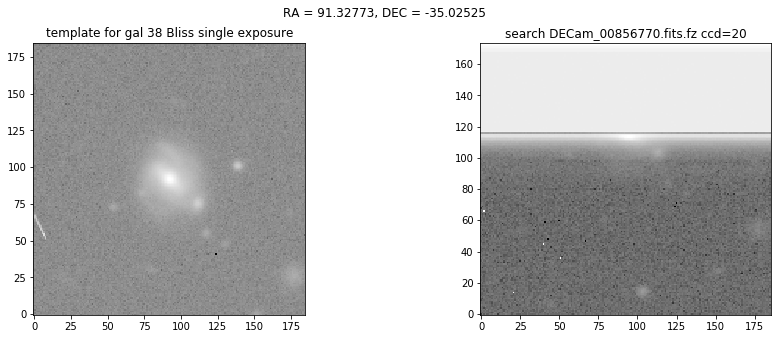

9 cutout: rows,cols 1624:1810  1034:1221
Exposure available in  r
Closest object is at distance [0d00m00.3721s]
(RA,DEC)= 90.85843535826422 -34.93414901507275
Filter, mag, magerr r 16.219154 0.0016871329
Opening file: /data/des61.b/data/BLISS/502100/502134/D00502134_r_05_r1p1_immask.fits.fz
cutout: 92 1832.678444281366 1826.7742436829458
trying search + Bliss single exposure



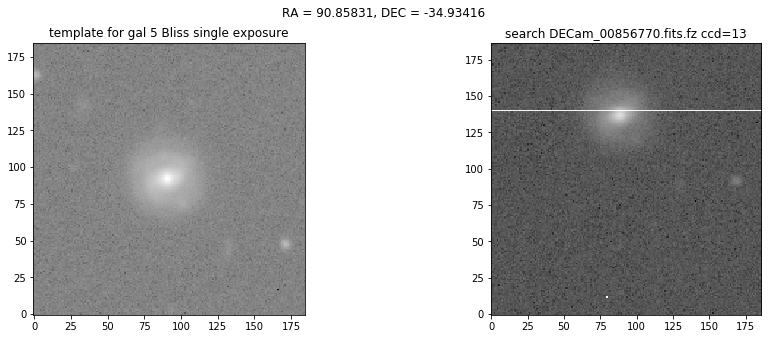

cutout: rows,cols 3821:4007  554:741
Exposure available in  r
Closest object is at distance [0d00m00.1353s]
(RA,DEC)= 91.05419849835889 -34.90071693684153
Filter, mag, magerr r 16.060762 0.0013032698
Opening file: /data/des61.b/data/BLISS/597600/597684/D00597684_r_12_r1p1_immask.fits.fz
cutout: 92 1907.6828888103519 692.5543660426415
trying search + Bliss single exposure



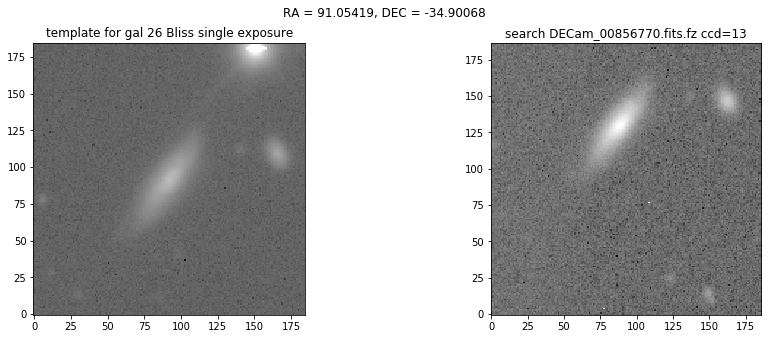

cutout: rows,cols 666:852  2145:2332
Exposure available in  r
Closest object is at distance [0d00m08.3678s]
(RA,DEC)= 90.76900767936225 -35.01465452751373
Filter, mag, magerr r 20.06577 0.015714703
Opening file: /data/des61.b/data/BLISS/502100/502134/D00502134_r_09_r1p1_immask.fits.fz
cutout: 92 682.7017861887325 2985.8148612046757
trying search + Bliss single exposure



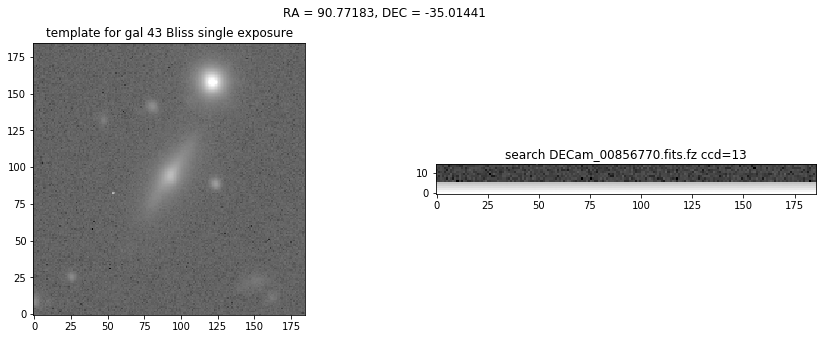

10 11 cutout: rows,cols 279:465  1169:1356
Exposure available in  r
Closest object is at distance [0d00m00.4096s]
(RA,DEC)= 90.93031937488014 -34.780446316914166
Filter, mag, magerr r 14.879756 0.0007714394
Opening file: /data/des61.b/data/BLISS/701100/701100/D00701100_r_59_r1p1_immask.fits.fz
cutout: 92 1431.2170377138918 2173.0152782946348
trying search + Bliss single exposure



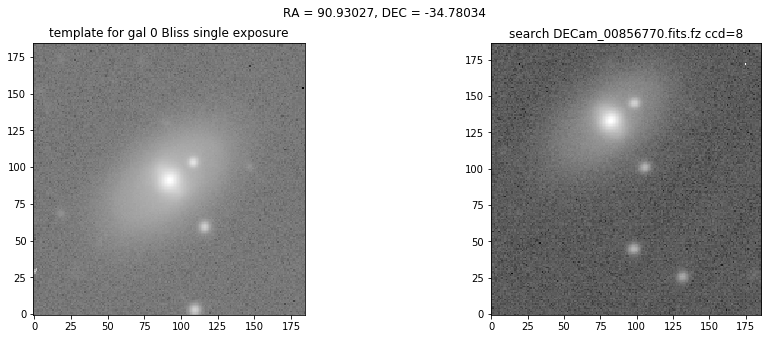

12 13 cutout: rows,cols 3695:3881  329:516
Exposure available in  r
Closest object is at distance [0d00m00.2485s]
(RA,DEC)= 91.04297520762543 -35.54556108865651
Filter, mag, magerr r 16.559309 0.002077372
Opening file: /data/des61.b/data/BLISS/502100/502134/D00502134_r_28_r1p1_immask.fits.fz
cutout: 92 1194.5363152470866 1765.9080361459423
trying search + Bliss single exposure



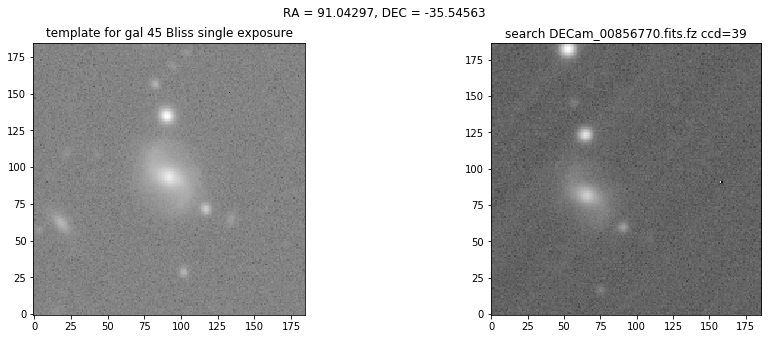

14 cutout: rows,cols 170:356  910:1097
Exposure available in  r
Closest object is at distance [0d00m21.9609s]
(RA,DEC)= 91.1001656074525 -35.58740660997618
Filter, mag, magerr r 20.067793 0.030618683
Opening file: /data/des61.b/data/BLISS/722600/722633/D00722633_r_33_r1p1_immask.fits.fz
cutout: 92 1353.659855210698 1431.4439415627646
trying search + Bliss single exposure



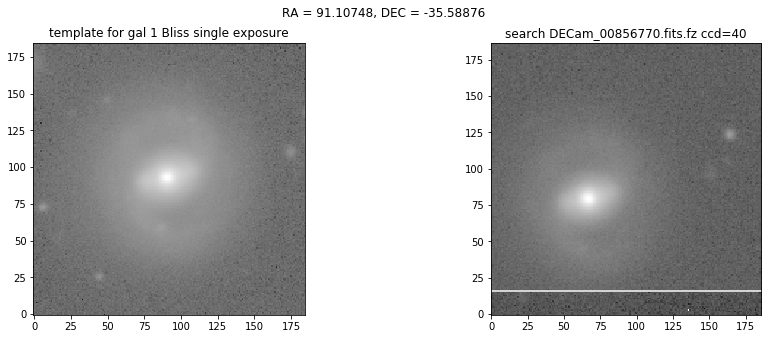

cutout: rows,cols 69:255  1094:1281
Exposure available in  r
Closest object is at distance [0d00m00.2644s]
(RA,DEC)= 91.09830762843097 -35.602152408056725
Filter, mag, magerr r 15.026434 0.0010907084
Opening file: /data/des61.b/data/BLISS/714200/714223/D00714223_r_17_r1p1_immask.fits.fz
cutout: 92 629.4545547299194 192.21227720260813
trying search + Bliss single exposure



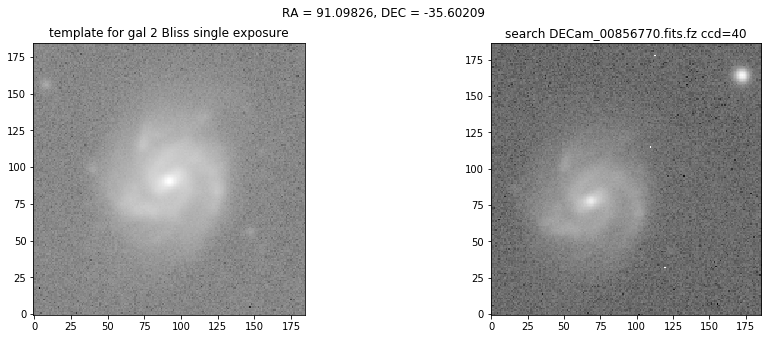

15 cutout: rows,cols 3453:3639  118:305
Exposure available in  r
Closest object is at distance [0d00m20.8577s]
(RA,DEC)= 91.02251707947828 -35.69947106113751
Filter, mag, magerr r 21.120237 0.03762964
Opening file: /data/des61.b/data/BLISS/714200/714223/D00714223_r_16_r1p1_immask.fits.fz
cutout: 92 1884.0705457691283 3559.869231965114
trying search + Bliss single exposure



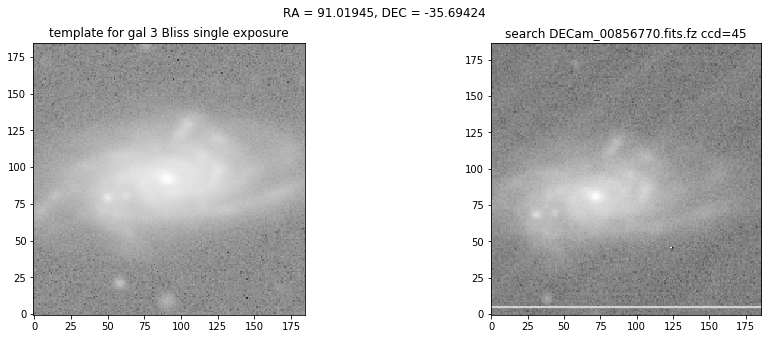

16 17 cutout: rows,cols 3289:3475  305:492
Exposure available in  r
Closest object is at distance [0d00m00.8046s]
(RA,DEC)= 91.19391176198931 -35.87394792200918
Filter, mag, magerr r 16.079521 0.0016069607
Opening file: /data/des61.b/data/BLISS/502100/502134/D00502134_r_42_r1p1_immask.fits.fz
cutout: 92 1178.6515199290056 1314.1614262820453
trying search + Bliss single exposure



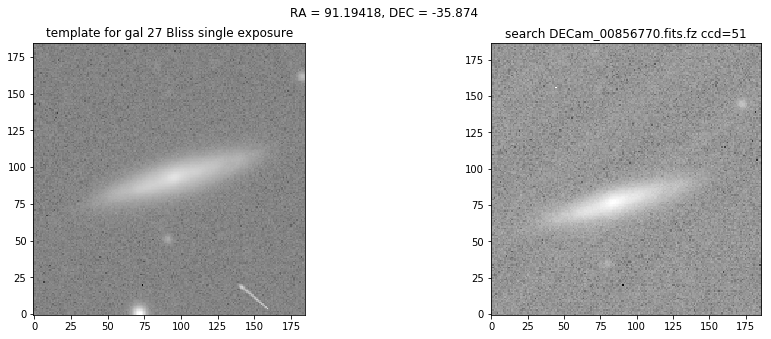

18 cutout: rows,cols 1270:1456  1873:2060
Exposure available in  r
Closest object is at distance [0d00m00.0897s]
(RA,DEC)= 91.20129049305936 -36.1487338552988
Filter, mag, magerr r 16.239656 0.0020325934
Opening file: /data/des61.b/data/BLISS/502100/502134/D00502134_r_53_r1p1_immask.fits.fz
cutout: 92 439.02831836734276 3510.7722793583166
trying search + Bliss single exposure



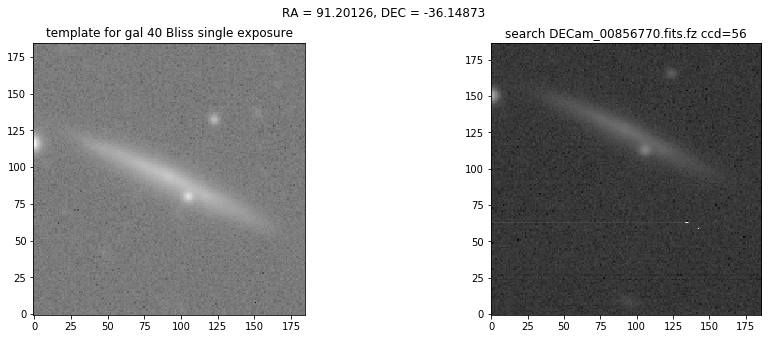

cutout: rows,cols 3049:3235  2122:2309
Exposure available in  r
Closest object is at distance [0d00m00.5849s]
(RA,DEC)= 91.36196295361505 -36.16796325581807
Filter, mag, magerr r 16.420717 0.0020031745
Opening file: /data/des61.b/data/BLISS/722600/722633/D00722633_r_56_r1p1_immask.fits.fz
cutout: 92 265.4481393514543 2169.151497015249
trying search + Bliss single exposure



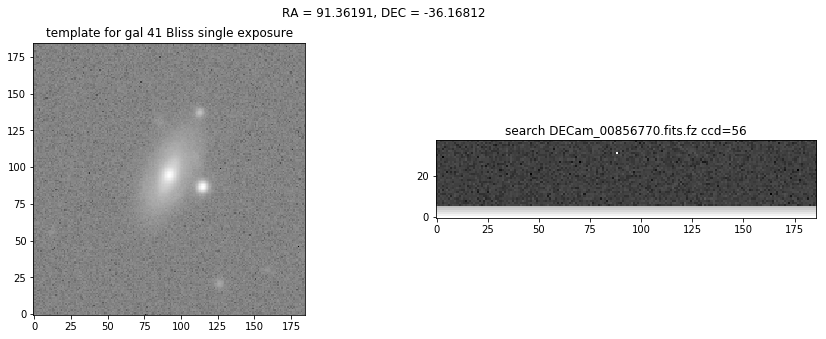

cutout: rows,cols 2436:2622  42:229
Exposure available in  r
Closest object is at distance [0d00m00.1408s]
(RA,DEC)= 91.3076533452692 -36.0161602319888
Filter, mag, magerr r 16.588242 0.0020462272
Opening file: /data/des61.b/data/BLISS/714200/714223/D00714223_r_30_r1p1_immask.fits.fz
cutout: 92 1799.4512492512383 348.51450350651095
trying search + Bliss single exposure



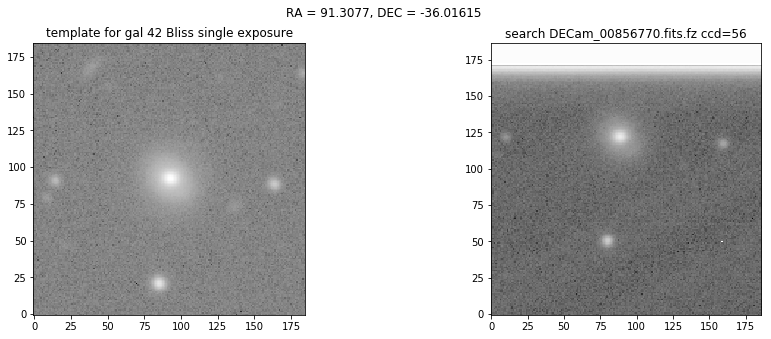

19 20 21 cutout: rows,cols 3464:3650  1709:1896
Exposure available in  r
Closest object is at distance [0d00m00.2676s]
(RA,DEC)= 92.53969388431378 -35.15269593402273
Filter, mag, magerr r 16.12663 0.0015032394
Opening file: /data/des60.b/data/BLISS/598300/598370/D00598370_r_58_r1p1_immask.fits.fz
cutout: 92 1240.8763191661892 3794.0786362921726
trying search + Bliss single exposure



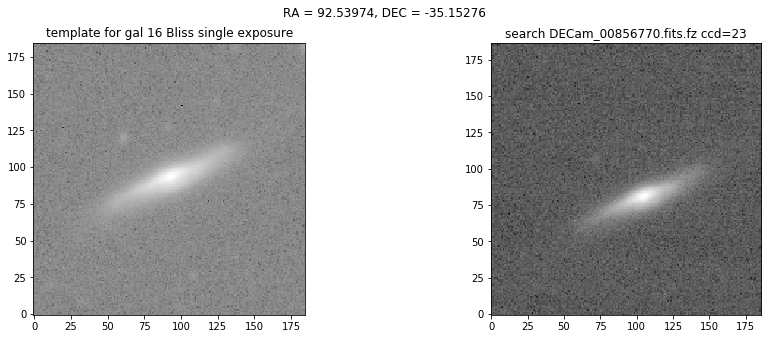

22 23 cutout: rows,cols 3958:4144  1201:1388
Exposure available in  r
Closest object is at distance [0d00m00.4779s]
(RA,DEC)= 92.58207595109042 -34.950950223537404
Filter, mag, magerr r 15.938811 0.0011578713
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_11_r1p1_immask.fits.fz
cutout: 92 1435.5270682494047 2723.8375847356397
trying search + Bliss single exposure



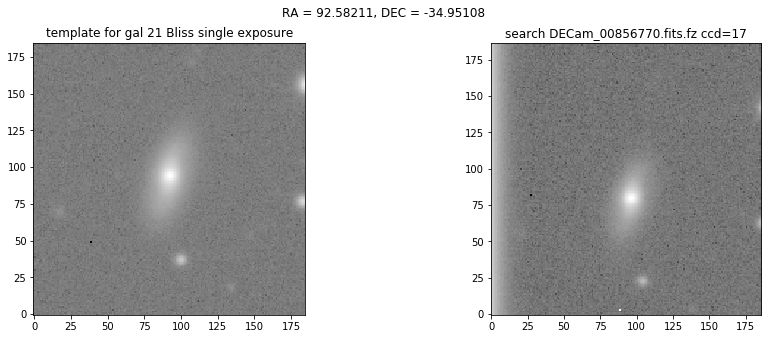

cutout: rows,cols 1562:1748  1659:1846
Exposure available in  r
Closest object is at distance [0d00m00.371s]
(RA,DEC)= 92.36898420197589 -34.98499319238617
Filter, mag, magerr r 16.368391 0.0014519123
Opening file: /data/des60.b/data/BLISS/598300/598370/D00598370_r_53_r1p1_immask.fits.fz
cutout: 92 1181.8837673470616 4010.1882648462665
trying search + Bliss single exposure



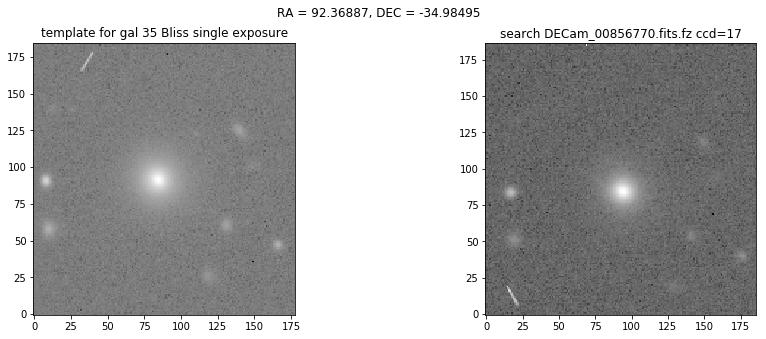

24 25 26 27 cutout: rows,cols 3176:3362  1699:1886
Exposure available in  r
Closest object is at distance [0d00m00.1563s]
(RA,DEC)= 91.56513977301115 -34.82259563170799
Filter, mag, magerr r 15.137229 0.0010233066
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_04_r1p1_immask.fits.fz
cutout: 92 1920.3621208233017 1939.3576522737844
trying search + Bliss single exposure



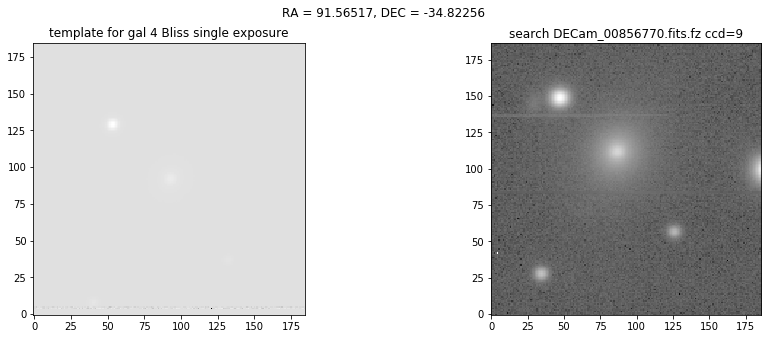

28 29 cutout: rows,cols 2441:2627  1053:1240
Exposure available in  r
Closest object is at distance [0d00m11.8736s]
(RA,DEC)= 92.25339701028695 -34.7782272998045
Filter, mag, magerr r 20.182789 0.014273234
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_06_r1p1_immask.fits.fz
cutout: 92 1283.8311901807465 1207.474039467943
trying search + Bliss single exposure



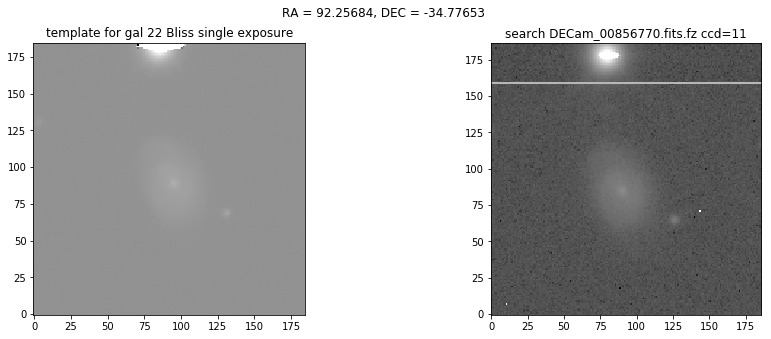

cutout: rows,cols 3692:3878  1040:1227
Exposure available in  r
Closest object is at distance [0d00m00.895s]
(RA,DEC)= 92.36836402565899 -34.77530658300451
Filter, mag, magerr r 16.252483 0.0014863502
Opening file: /data/des61.b/data/BLISS/722600/722633/D00722633_r_07_r1p1_immask.fits.fz
cutout: 92 1463.682655009583 633.530815722283
trying search + Bliss single exposure



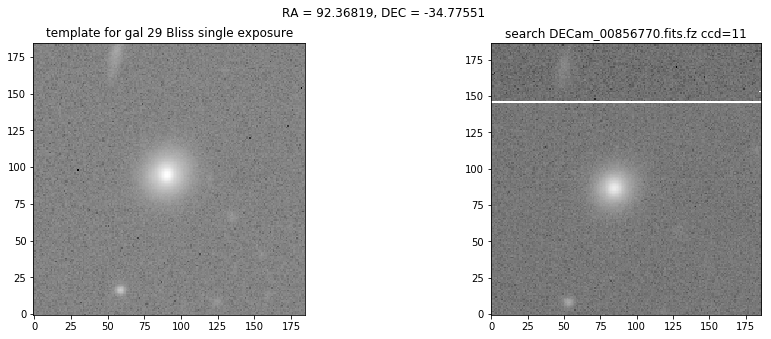

30 31 cutout: rows,cols 1771:1957  1457:1644
Exposure available in  r
Closest object is at distance [0d00m00.9099s]
(RA,DEC)= 91.63072438421302 -34.64106871612488
Filter, mag, magerr r 14.395314 0.00059868954
Opening file: /data/des60.b/data/BLISS/598300/598370/D00598370_r_40_r1p1_immask.fits.fz
cutout: 92 985.2956033401224 2099.470201878816
trying search + Bliss single exposure



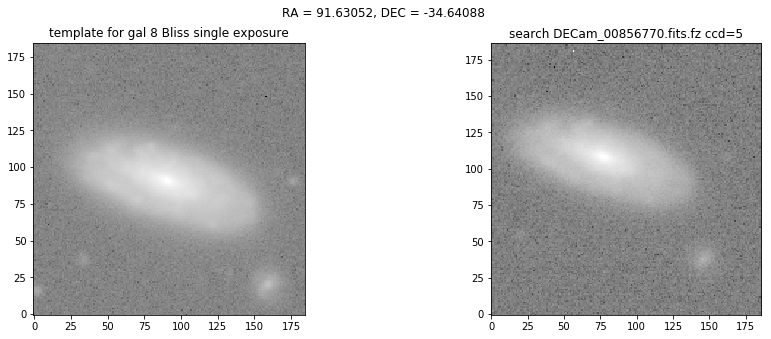

32 33 cutout: rows,cols 1870:2056  1943:2130
Exposure available in  r
Closest object is at distance [0d00m00.4012s]
(RA,DEC)= 92.39459732456012 -34.67727442517505
Filter, mag, magerr r 16.233418 0.001546733
Opening file: /data/des61.b/data/BLISS/722600/722633/D00722633_r_07_r1p1_immask.fits.fz
cutout: 92 115.48318525285322 939.3961433493299
trying search + Bliss single exposure



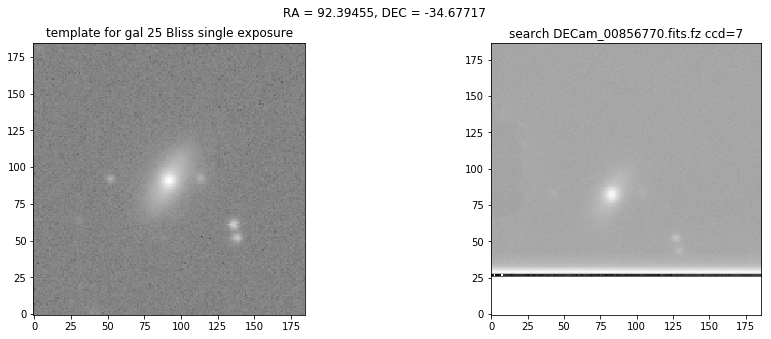

cutout: rows,cols 317:503  1357:1544
Exposure available in  r
Closest object is at distance [0d00m00.437s]
(RA,DEC)= 92.25652881180564 -34.63447095035537
Filter, mag, magerr r 16.231953 0.0013846935
Opening file: /data/des60.b/data/BLISS/598300/598370/D00598370_r_42_r1p1_immask.fits.fz
cutout: 92 883.9127371191689 632.3649791151994
trying search + Bliss single exposure



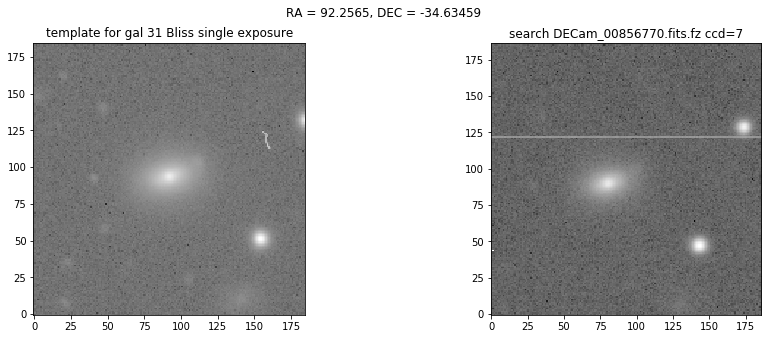

cutout: rows,cols 1325:1511  1176:1363
Exposure available in  r
Closest object is at distance [0d00m00.4681s]
(RA,DEC)= 92.34598635229595 -34.62122199992288
Filter, mag, magerr r 16.599232 0.002021023
Opening file: /data/des60.b/data/BLISS/598300/598370/D00598370_r_42_r1p1_immask.fits.fz
cutout: 92 704.9885595054147 1637.2041998660288
trying search + Bliss single exposure



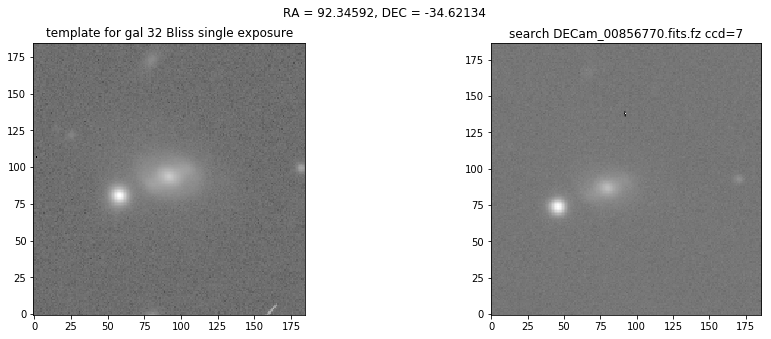

34 35 36 37 38 39 40 41 42 43 44 45 cutout: rows,cols 2389:2575  802:989
Exposure available in  r
Closest object is at distance [0d00m00.724s]
(RA,DEC)= 91.6891554495613 -35.58410585458409
Filter, mag, magerr r 15.002517 0.001098564
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_34_r1p1_immask.fits.fz
cutout: 92 1082.8504368640486 1258.9349724779765
trying search + Bliss single exposure



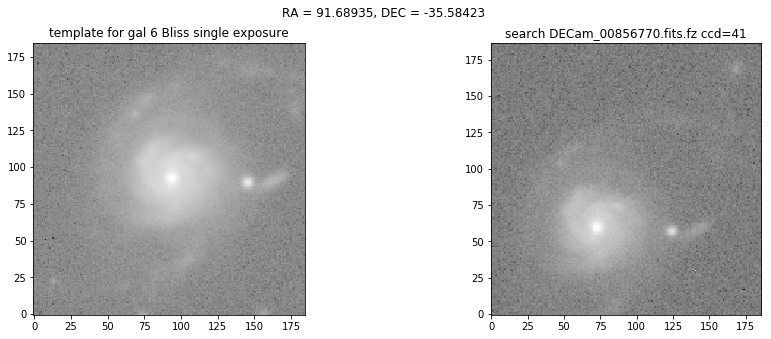

cutout: rows,cols 572:758  249:436
Exposure available in  r
Closest object is at distance [0d00m00.5469s]
(RA,DEC)= 91.52617632935362 -35.54299812825847
Filter, mag, magerr r 16.364653 0.0019068469
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_33_r1p1_immask.fits.fz
cutout: 92 530.183950497358 3689.564429523907
trying search + Bliss single exposure



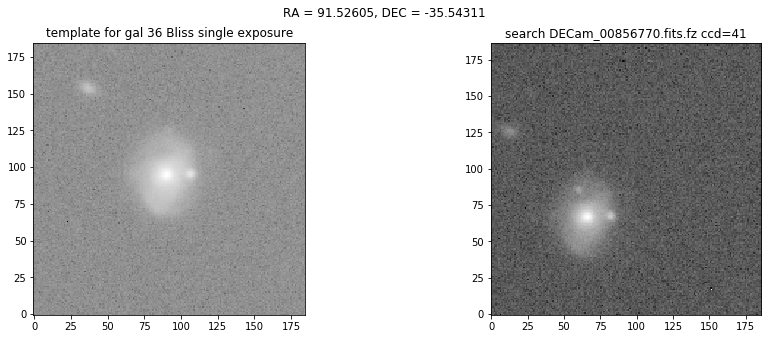

46 cutout: rows,cols 3011:3197  1178:1365
Exposure available in  r
Closest object is at distance [0d00m18.2452s]
(RA,DEC)= 92.13204890203343 -35.6165168856514
Filter, mag, magerr r 18.204111 0.007694989
Opening file: /data/des60.b/data/BLISS/598300/598371/D00598371_r_04_r1p1_immask.fits.fz
cutout: 92 4.328600783248476 3474.404728638301
trying search + Bliss single exposure

exception, search image has shape (187, 186)
47 cutout: rows,cols 208:394  0:181
Exposure available in  r
Closest object is at distance [0d00m21.5118s]
(RA,DEC)= 92.25741200407285 -35.53163064631819
Filter, mag, magerr r 19.361305 0.007309724
Opening file: /data/des61.b/data/BLISS/722600/722633/D00722633_r_36_r1p1_immask.fits.fz
cutout: 92 468.3156739469766 1476.9592440607366
trying search + Bliss single exposure



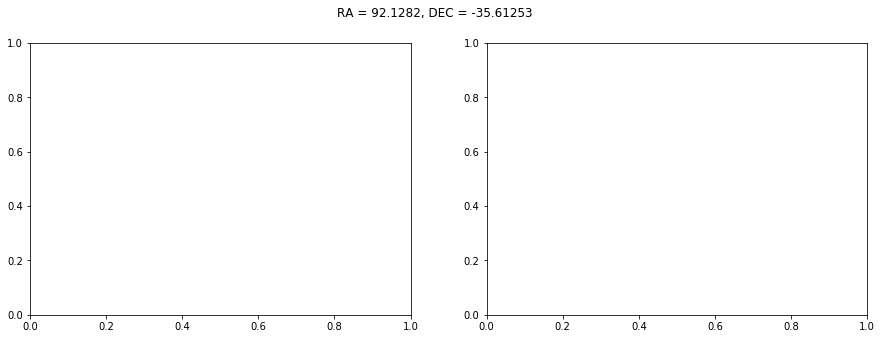

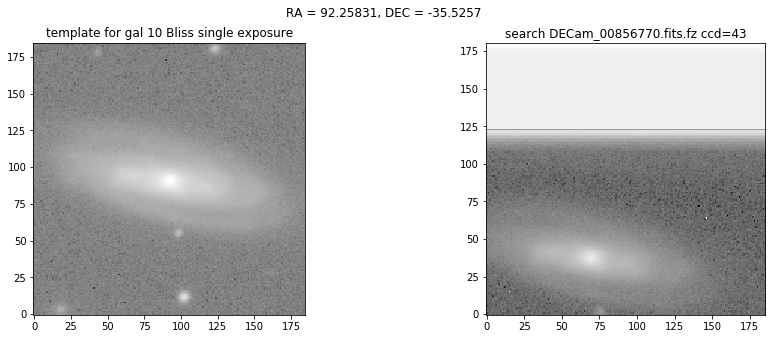

cutout: rows,cols 2406:2592  2019:2206
Exposure available in  r
Closest object is at distance [0d00m00.227s]
(RA,DEC)= 92.4562288364663 -35.673264804442525
Filter, mag, magerr r 15.290049 0.0011591526
Opening file: /data/des60.b/data/BLISS/598300/598371/D00598371_r_05_r1p1_immask.fits.fz
cutout: 92 835.3358868694268 2875.517846359846
trying search + Bliss single exposure



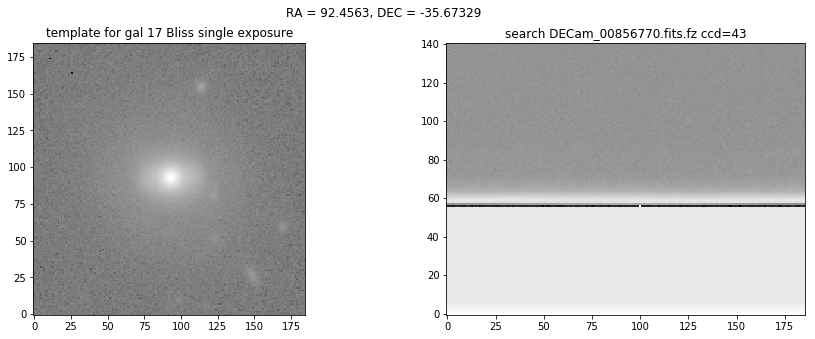

cutout: rows,cols 1446:1632  1700:1887
Exposure available in  r
Closest object is at distance [0d00m00.3062s]
(RA,DEC)= 92.36980441812241 -35.650171150537055
Filter, mag, magerr r 16.038452 0.0020334488
Opening file: /data/des60.b/data/BLISS/598300/598371/D00598371_r_05_r1p1_immask.fits.fz
cutout: 92 518.8991578754831 1914.6742766568038
trying search + Bliss single exposure



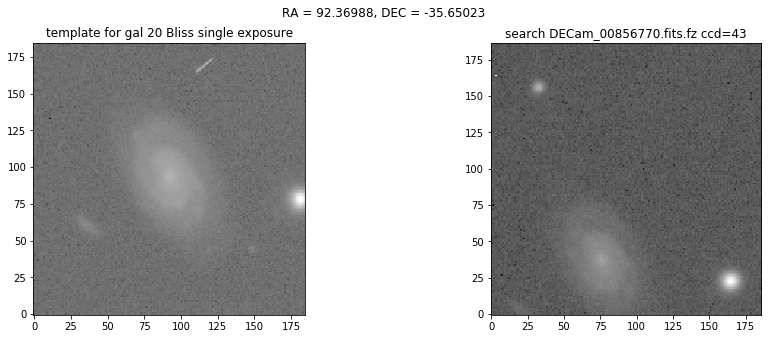

48 49 cutout: rows,cols 1275:1461  2035:2222
Exposure available in  r
Closest object is at distance [0d00m00.3795s]
(RA,DEC)= 92.35485419568762 -35.839215810340086
Filter, mag, magerr r 15.978275 0.0013236388
Opening file: /data/des60.b/data/BLISS/598300/598371/D00598371_r_09_r1p1_immask.fits.fz
cutout: 92 857.7928120525748 3877.8118710996628
trying search + Bliss single exposure



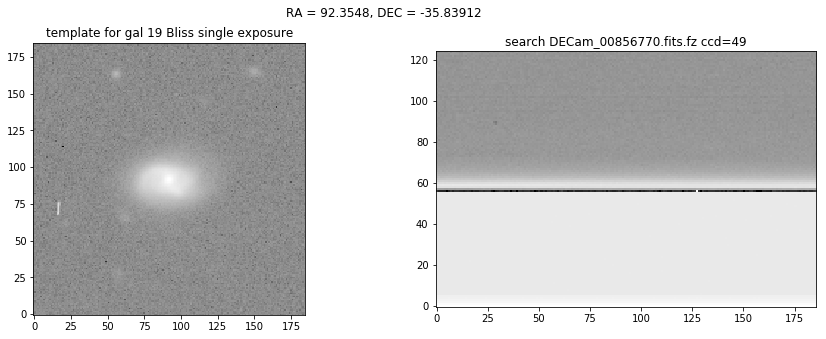

50 51 52 53 cutout: rows,cols 2343:2529  1507:1694
Exposure available in  r
Closest object is at distance [0d00m01.0816s]
(RA,DEC)= 91.4912113640888 -35.963970148406815
Filter, mag, magerr r 14.181759 0.00067414995
Opening file: /data/des60.b/data/BLISS/598300/598371/D00598371_r_13_r1p1_immask.fits.fz
cutout: 92 357.30543264796415 686.3255949062631
trying search + Bliss single exposure



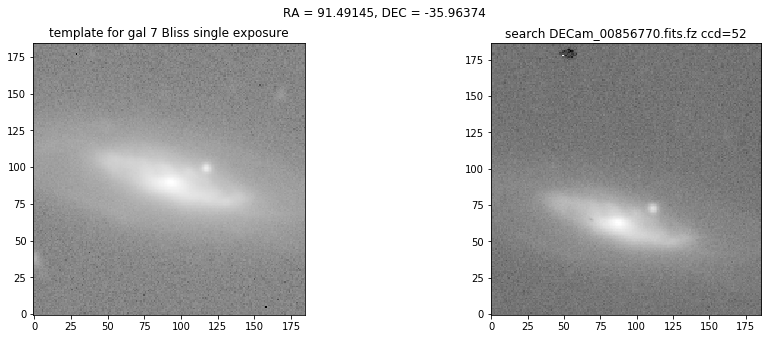

cutout: rows,cols 1083:1269  390:577
Exposure available in  r
Closest object is at distance [0d00m00.8653s]
(RA,DEC)= 91.37843794749105 -35.88134103925957
Filter, mag, magerr r 17.464773 0.0028261563
Opening file: /data/des61.b/data/BLISS/597600/597684/D00597684_r_50_r1p1_immask.fits.fz
cutout: 92 1860.4837436239977 2069.8289199587716
trying search + Bliss single exposure



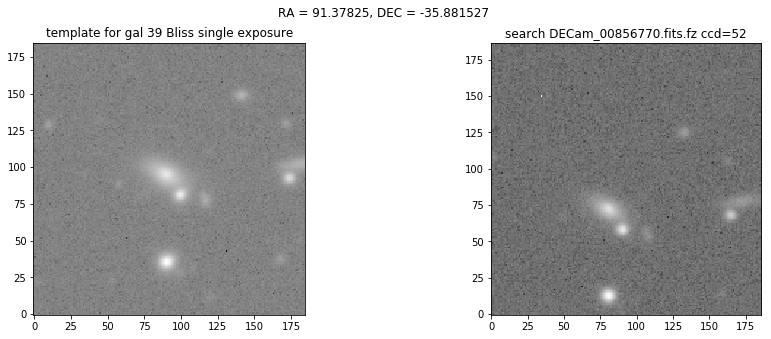

54 55 56 cutout: rows,cols 385:571  168:355
Exposure available in  r
Closest object is at distance [0d00m00.5273s]
(RA,DEC)= 92.46587249526571 -35.86656496640167
Filter, mag, magerr r 15.332803 0.0010153943
Opening file: /data/des61.b/data/BLISS/722600/722633/D00722633_r_49_r1p1_immask.fits.fz
cutout: 92 642.8177194369928 1632.838129682766
trying search + Bliss single exposure



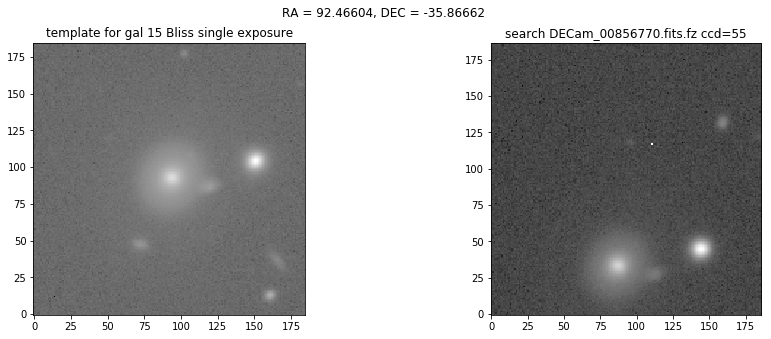

57 cutout: rows,cols 2264:2450  1008:1195
Exposure available in  r
Closest object is at distance [0d00m00.3869s]
(RA,DEC)= 91.67569252469525 -36.088562705991606
Filter, mag, magerr r 16.699043 0.0024813802
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_52_r1p1_immask.fits.fz
cutout: 92 1234.5163450003447 1126.9605332716444
trying search + Bliss single exposure



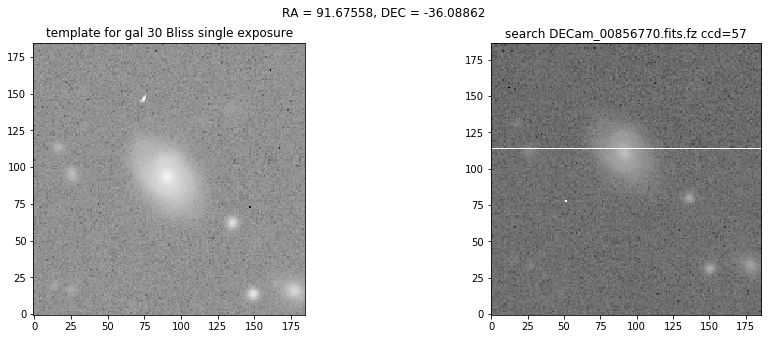

58 cutout: rows,cols 3054:3240  839:1026
Exposure available in  r
Closest object is at distance [0d00m20.2541s]
(RA,DEC)= 92.12498418780278 -36.075573951696136
Filter, mag, magerr r 18.897097 0.0053120092
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_53_r1p1_immask.fits.fz
cutout: 92 1063.119183741118 1915.6210668953097
trying search + Bliss single exposure



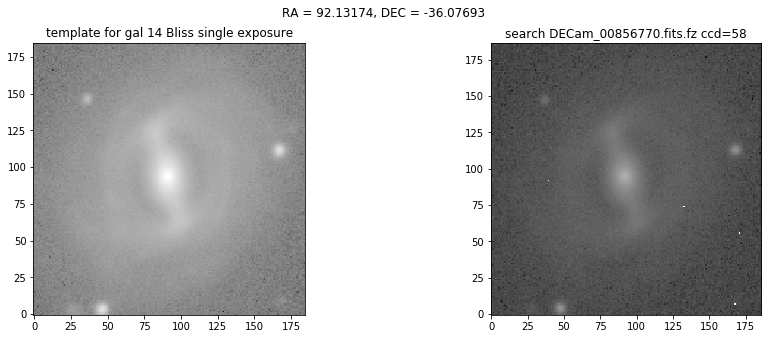

59 cutout: rows,cols 2467:2653  937:1124
Exposure available in  r
Closest object is at distance [0d00m00.4351s]
(RA,DEC)= 92.46261025624285 -36.08318399372666
Filter, mag, magerr r 16.483006 0.001580833
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_54_r1p1_immask.fits.fz
cutout: 92 1154.64361780335 1322.69804456557
trying search + Bliss single exposure



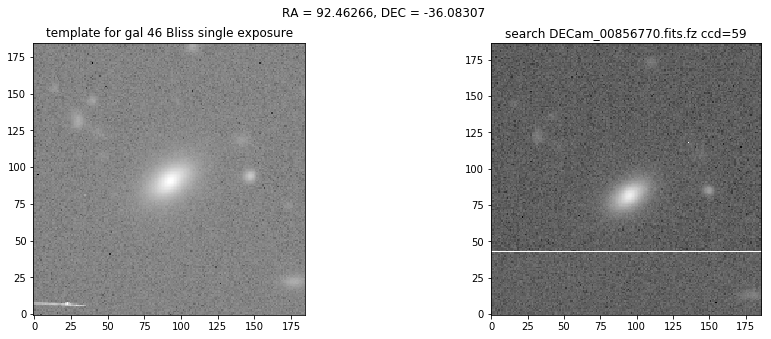

60 61 62 cutout: rows,cols 3059:3245  758:945
Exposure available in  r
Closest object is at distance [0d00m00.1625s]
(RA,DEC)= 92.32459935186444 -36.23465841618109
Filter, mag, magerr r 16.21925 0.0012946194
Opening file: /data/des61.b/data/BLISS/613700/613773/D00613773_r_58_r1p1_immask.fits.fz
cutout: 92 977.9101290383551 1917.9563273258136
trying search + Bliss single exposure



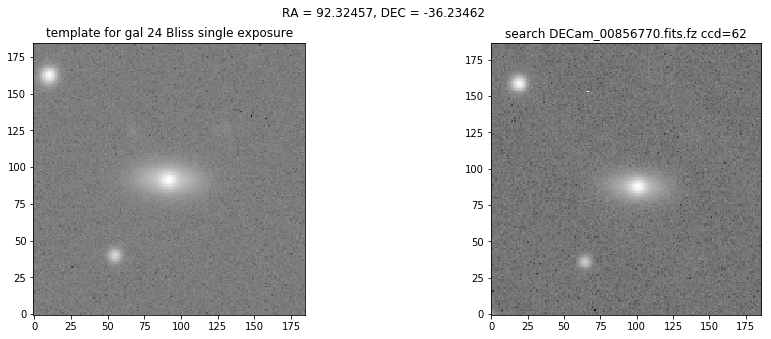


 Did 38 galaxies!



In [222]:
image_ra, image_dec =91.841025,-35.34666
image_name = "856770"; filter="r"

work_image(image_name, image_ra,image_dec, filter=filter, do_cutout=False, do_num=-1)

# Do the Eyeballing!

This is the action cell!

For a given image, get the 
image name, ra, dec

Change the triplets,
then run the cell, it will take time to do all of them

Exposure available in  g
Closest object is at distance [0d00m00.425s]
(RA,DEC)= 87.99563215539527 -31.78410788000979
Filter, mag, magerr g 17.56227 0.0035836191
Opening file: /data/des60.b/data/BLISS/598300/598368/D00598368_g_10_r1p1_immask.fits.fz
cutout: 55 899.191496296753 1716.0683675197808
Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856743.fits.fz
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 Not Found


TypeError: Invalid dimensions for image data

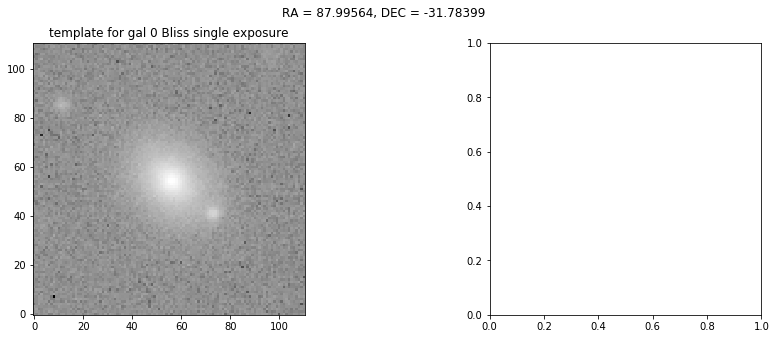

In [99]:
image_ra, image_dec = 87.42528, -30.7226
image_name = "DECam_00856743.fits.fz"
gra,gdec,thumbs = get_list_of_gals_and_cutouts(image_ra, image_dec)

#gra,gdec = np.ones(2)*image_ra, np.ones(2)*image_dec
#thumbs[0] = 'DESJ054942.1-304321.4'
#thumbs[1] = 'DESJ054942.1-304321.4'


pixscal=.27
for i in range(gra.size) :
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(gra[i],6))+', DEC = '+str(round(gdec[i],6)))
    
    match_cutout = 15
    go_big = 25
    if i == 1 :
        template = get_des_cutout_image(thumbs[i])
        label = "DES coadd"
        size = match_cutout/0.27
    
    if i == 0:
        template = find_BLISS_image(gra[i],gdec[i],size)
        label = "Bliss single exposure"
        size = go_big/0.27
    search = find_search_image(image_name,gra[i],gdec[i],size)
    #print search
    #if search == -1 or search == []: continue

    
    axs[0].imshow(np.log10(template-np.amin(template)+1),origin='lower',cmap='gray')
    axs[0].set_title('template for gal {} {}'.format(i, label))
    axs[1].imshow(np.log10(search-np.amin(search)+1),origin='lower',cmap='gray')
    axs[1].set_title('search for gal {}'.format(i))
    plt.show()

In [ ]:

# save new cutout to new folder
def get_search_image(RA,DEC,size,
                     fname="DECam_00850304.fits.fz",
                     path="/data/des51.b/data/DTS/src/20190509/"):
    # open new file
    hdul=fits.open(fname)
    header0=hdul[0].header
    
    for hdu in hdul[1:]:
        header=hdu.header
        img=np.array(hdu.data)
        
        # Parse the WCS keywords in the primary HDU
        w = wcs.WCS(header)
    
        wcoords=np.array([RA,DEC]).reshape((1,2))
        pixs=w.all_world2pix(wcoords,1)[0]
        
        if 0<=pixs[0]<img.shape[1] and 0<=pixs[1]<img.shape[0]:
            
            cutout=np.flip(np.flip(np.array(img[int(max(0,pixs[1]-size/2.)):int(min(img.shape[0],pixs[1]+size/2.)),
                            int(max(0,pixs[0]-size/2.)):int(min(img.shape[1],pixs[0]+size/2.))]),1).transpose(),1)
            
            #write file
            new_filename=path+'RA'+str(RA)+'_DEC'+str(DEC)+'.fits'
            try: fits.writeto(new_filename, cutout, header)
            except OSError:
                try:
                    os.remove(new_filename)
                    fits.writeto(new_filename, cutout, header)
                except OSError:
                    print('file saving error with '+str(RA)+', '+str(DEC))

            return cutout
        
    return 'coordinates not found'

In [ ]:
# example data

new_path='./new_images/'
RA_ls=[88.76485]
DEC_ls=[-33.14772]
    
pixscal=.27
for i in range(len(file_ls)):
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(RA_ls[i],6))+', DEC = '+str(round(DEC_ls[i],6)))
    
#     if not os.path.isfile(template_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    #template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    
#     if not os.path.isfile(new_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    new_cutout=get_search_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,original_path+file_ls[i],template_path)
#     new_cutout=np.array(new_cutout)
    
    axs[0].imshow(np.log10(template_cutout-np.amin(template_cutout)+1),origin='lower',cmap='gray')
    axs[0].set_title('template')
    axs[1].imshow(np.log10(new_cutout-np.amin(new_cutout)+1),origin='lower',cmap='gray')
    axs[1].set_title('new')
    plt.show()

In [ ]:
#Antonella's changes 04/29/2019 to make this work with BLISS images
#This part also finds if there are previous detections of the candidate!

In [ ]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS


def cutout(infilename,ra,dec,stampSize, outfile): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    plt.imshow(data, origin='lower',cmap='gray')
    plt.title('RA='+str(ra)+', DEC='+str(dec))
    #Save outfile

def find_BLISS_image(cand_ra,cand_dec,stampSize):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if os.path.isfile(cat_file):
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                cutout(exp_file,cand_ra,cand_dec,stampSize,outfile) #cand_ra,cand_dec

        else:
            print "There is no source catalog in ", band
            exp_file = 0

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
#AP: Not sure what this does, it was the third entry

# open headless browser
# laptop
# driver=webdriver.Firefox(executable_path='/Users/jmetzger/anaconda3/bin/geckodriver')
# des machines
driver=webdriver.Firefox(executable_path='/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/geckodriver')
browser=Browser(headless=True)
# the geckodriver executable needs to be in the environmental variable $PATH
# export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/

